In [9]:
# Imports
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score
from bayes_opt import BayesianOptimization
import scipy.interpolate
import time
import xgboost as xgb

# Definitions
pd.set_option('display.float_format', lambda x: '%.4f' % x)
%matplotlib inline
warnings.simplefilter('ignore')
N_JOBS = -1
FOLDS = 3
SEED = 2017

In [2]:
# Fit, predict and return error
def run_et(max_features, max_depth, min_samples_split, min_samples_leaf) :
    # Define train and test sets for BO process
    oof_preds = pd.DataFrame()
    oof_targets = pd.DataFrame()
    kf = KFold(n_splits = FOLDS, shuffle = True, random_state = SEED)
    for i, (train_index, test_index) in enumerate(kf.split(train)):
        X_train, X_val = train.iloc[train_index], train.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]
       
        # Fit model
        et = ExtraTreesRegressor(n_estimators = 100, 
                                 max_features = max_features, 
                                 max_depth = int(max_depth), 
                                 min_samples_split = int(min_samples_split), 
                                 min_samples_leaf = int(min_samples_leaf), 
                                 n_jobs = -1, 
                                 random_state = SEED)
        et.fit(X_train, y_train)

        # Compute score on this fold
        preds_val = et.predict(X_val)    
        
        # Store OOF predictions
        oof_preds = pd.concat([pd.Series(oof_preds), pd.Series(preds_val)], axis = 0)
        oof_targets = pd.concat([pd.Series(oof_targets), pd.Series(y_val.y)], axis = 0)
    
    # Compte error on OOF predictions
    cv_score = r2_score(oof_targets, oof_preds)

    return(cv_score)


'''def run_xgb(max_depth, min_child_weight, subsample, colsample_bytree, colsample_bylevel) :

    def xgb_mse(preds, dtrain) :
        labels = dtrain.get_label()
        return ("mse", mean_squared_error(preds, labels))

    xg_params = {"nthread" : N_JOBS, 
                 "eta" : 0.3, 
                 "max_depth" : int(max_depth), 
                 "min_child_weight" : int(min_child_weight), 
                 "subsample" : subsample, 
                 "colsample_bytree" : colsample_bytree, 
                 "colsample_bylevel" : colsample_bylevel}    
    
    xg_trainVal = xgb.DMatrix(X_trainVal, label = y_trainVal)
    xg_testVal = xgb.DMatrix(X_testVal, label = y_testVal)
    xg_train = xgb.DMatrix(X_train, label = y_train)
    
    watchlist = [(xg_trainVal, "train"), (xg_testVal, "eval")]    
    
    # Fit model using validation set
    xg = xgb.train(
        params = xg_params,
        dtrain = xg_trainVal,
        evals = watchlist, 
        num_boost_round = 100000,
        early_stopping_rounds = 50,
        feval = xgb_mse, 
        maximize = False,
        verbose_eval = False)
    
    # Now fit on whole training set
    xg2 = xgb.train(
        params = xg_params, 
        dtrain = xg_train, 
        num_boost_round = int(xg.best_ntree_limit / 0.67),
        feval = xgb_mse, 
        maximize = False,
        verbose_eval = False)
    
    # Make predictions
    xg_test = xgb.DMatrix(X_test)
    preds = xg2.predict(xg_test) 

    # Compute error
    score = r2_score(y_test, preds)

    return((-1) * rmse)'''

'def run_xgb(max_depth, min_child_weight, subsample, colsample_bytree, colsample_bylevel) :\n\n    def xgb_mse(preds, dtrain) :\n        labels = dtrain.get_label()\n        return ("mse", mean_squared_error(preds, labels))\n\n    xg_params = {"nthread" : N_JOBS, \n                 "eta" : 0.3, \n                 "max_depth" : int(max_depth), \n                 "min_child_weight" : int(min_child_weight), \n                 "subsample" : subsample, \n                 "colsample_bytree" : colsample_bytree, \n                 "colsample_bylevel" : colsample_bylevel}    \n    \n    xg_trainVal = xgb.DMatrix(X_trainVal, label = y_trainVal)\n    xg_testVal = xgb.DMatrix(X_testVal, label = y_testVal)\n    xg_train = xgb.DMatrix(X_train, label = y_train)\n    \n    watchlist = [(xg_trainVal, "train"), (xg_testVal, "eval")]    \n    \n    # Fit model using validation set\n    xg = xgb.train(\n        params = xg_params,\n        dtrain = xg_trainVal,\n        evals = watchlist, \n        num_bo

In [3]:
# Init Bayesian Optimization
et_max_features_min = 0.5
et_max_features_max = 1.0
et_max_depth_min = 3
et_max_depth_max = 7
et_min_samples_split_min = 2
et_min_samples_split_max = 10
et_min_samples_leaf_min = 2
et_min_samples_leaf_max = 10

xgb_max_depth_min = 5
xgb_max_depth_max = 12
xgb_min_child_weight_min = 10
xgb_min_child_weight_max = 25
xgb_subsample_min = 0.4
xgb_subsample_max = 0.9
xgb_colsample_bytree_min = 0.4
xgb_colsample_bytree_max = 1.0
xgb_colsample_bylevel_min = 0.3
xgb_colsample_bylevel_max = 1.0


def initBO() :
    if (MODEL == "et") :
        # Define the features to explore
        bo = BayesianOptimization(run_et, {
            "max_features" : (et_max_features_min, et_max_features_max), 
            "max_depth" : (et_max_depth_min, et_max_depth_max),
            "min_samples_split" : (et_min_samples_split_min, et_min_samples_split_max),
            "min_samples_leaf" : (et_min_samples_leaf_min, et_min_samples_leaf_max),
        })
        
        # Define the initial exploration : 10 points approximately covering the range of each parameter
        bo.explore({
            "max_features" : [0.8, 0.9, 0.5, 0.6, 0.8, 1.0, 0.7, 0.5, 0.6, 0.9],
            "max_depth" : [3, 7, 5, 6, 4, 7, 4, 7, 5, 3], 
            "min_samples_split" : [5, 2, 10, 3, 6, 8, 4, 9, 3, 6],
            "min_samples_leaf" : [4, 10, 4, 8, 3, 5, 6, 3, 7, 9]
        })
    elif (MODEL == "xg") :
        # Define the features to explore
        bo = BayesianOptimization(run_xgb, {
            "max_depth" : (xgb_max_depth_min, xgb_max_depth_max), 
            "min_child_weight" : (xgb_min_child_weight_min, xgb_min_child_weight_max),
            "subsample" : (xgb_subsample_min, xgb_subsample_max),
            "colsample_bytree" : (xgb_colsample_bytree_min, xgb_colsample_bytree_max),
            "colsample_bylevel" : (xgb_colsample_bylevel_min, xgb_colsample_bylevel_max), 
        })
        
        # Define the initial exploration : 10 points approximately covering the range of each parameter
        bo.explore({
            "max_depth" : [8, 6, 7, 12, 6, 5, 7, 8, 10, 9],
            "min_child_weight" : [14, 10, 30, 18, 10, 28, 25, 22, 17, 26],
            "subsample" : [0.6, 0.9, 0.7, 0.5, 0.6, 0.4, 0.7, 0.9, 0.5, 0.8],
            "colsample_bytree" : [0.4, 0.7, 1.0, 0.6, 0.9, 0.5, 0.8, 0.6, 0.8, 0.9], 
            "colsample_bylevel" :  [0.8, 0.6, 0.7, 1.0, 0.3, 0.9, 1.0, 0.5, 0.7, 0.4],
            })
    
    return(bo)

In [4]:
# Plot results of optimization
def graphBO(history_df, param1, param2, param1min, param1max, param2min, param2max, ratio) :
    x, y, z = history_df[param1].values, history_df[param2].values, history_df["RMSE"].values

    # Set up a regular grid of interpolation points
    xi, yi = np.linspace(param1min, param1max, 100), np.linspace(param2min, param2max, 100)
    xi, yi = np.meshgrid(xi, yi)

    # Interpolate
    rbf = scipy.interpolate.Rbf(x, y, z, function = "multiquadric", smooth = 0.5)
    zi = rbf(xi, yi)

    plt.figure()
    plt.imshow(zi, 
               cmap = "plasma", 
               aspect = ratio,
               vmin = z.min(), 
               vmax = z.max(), 
               origin = "lower",
               extent = [param1min, param1max, param2min, param2max])
    q = plt.scatter(x, y, c = z, cmap = "plasma")
    plt.colorbar(q)
    plt.xlabel(param1)
    plt.ylabel(param2)
    #plt.savefig("figures/XGB_" + param1 + "_" + param2 + ".png")
    plt.show(block = False)

<b>Script</b>

In [5]:
# Get data
train = pd.read_csv("clean_data/train.csv")
y = pd.read_csv("clean_data/y.csv")

display(train.shape)
display(train.head(2))
display(y.shape)
display(y.head(2))


(4209, 367)

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,srp_3,srp_4,srp_5,srp_6,srp_7,srp_8,srp_9,srp_10,srp_11,srp_12
0,0,10,21,44,0,3,20,9,14,0,...,126.974,-13.625,1.239,17.342,104.678,-3.716,-2.477,0.000,28.490,1.239
1,5761,14,11,29,5,3,15,9,14,0,...,119.613,-13.625,0.000,17.342,102.271,-2.477,2.477,0.000,13.625,1.239


(4209, 1)

,y
0,130.810
1,115.070


In [6]:
# Run optimization
MODEL = "et"
start = time.time()
bo = initBO()
bo.maximize(init_points = 10, n_iter = 140, xi = 0.05)
print("BayesianOptimization took %.2f seconds" % ((time.time() - start)))

Initialization
-------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_features |   min_samples_leaf |   min_samples_split | 
    1 | 00m00s |    0.56607 |      3.0000 |         0.8000 |             4.0000 |              5.0000 | 
    2 | 00m01s |    0.56135 |      7.0000 |         0.9000 |            10.0000 |              2.0000 | 
    3 | 00m00s |    0.56801 |      5.0000 |         0.5000 |             4.0000 |             10.0000 | 
    4 | 00m00s |    0.56564 |      6.0000 |         0.6000 |             8.0000 |              3.0000 | 
    5 | 00m00s |    0.56878 |      4.0000 |         0.8000 |             3.0000 |              6.0000 | 
    6 | 00m01s |    0.55791 |      7.0000 |         1.0000 |             5.0000 |              8.0000 | 
    7 | 00m00s |    0.56900 |      4.0000 |         0.7000 |             6.0000 |              4.0000 | 
    8 | 00m00s |    0.56284 |      7.0000

KeyboardInterrupt: 

In [10]:
# Store and look at results
history_df = pd.DataFrame(bo.res["all"]["params"])
history_df2 = pd.DataFrame(bo.res["all"]["values"])
history_df = pd.concat((history_df, history_df2), axis = 1)
history_df.rename(columns = { 0 : "RMSE"}, inplace = True)
history_df.index.names = ["Iteration"]
history_df.sort_values(["RMSE"], ascending = False, inplace = True)
#history_df.to_csv("../../data/temp_results/bo.csv")
display(history_df.head(10))

,max_depth,max_features,min_samples_leaf,min_samples_split,RMSE
Iteration,,,,,
61,4.2888,0.5257,2.0160,5.1725,0.5704
99,4.2103,0.5460,2.0644,6.2214,0.5703
92,4.6191,0.5232,2.0217,6.9260,0.5703
60,4.7673,0.5078,2.0135,9.2439,0.5702
35,5.3428,0.5227,2.0530,2.1068,0.5702
5,4.9395,0.5278,2.0824,4.6287,0.5701
64,4.4124,0.5273,2.0316,4.5736,0.5701
59,5.0103,0.5451,2.3263,2.4375,0.5701
21,4.6928,0.5098,2.5768,2.0114,0.5701


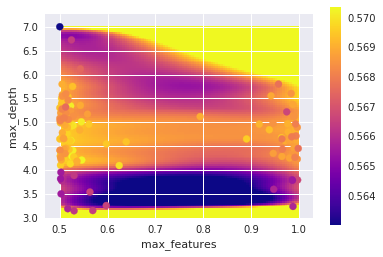

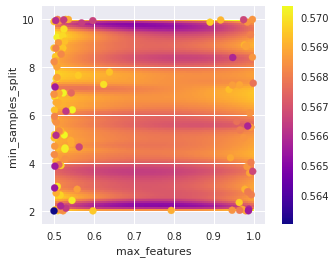

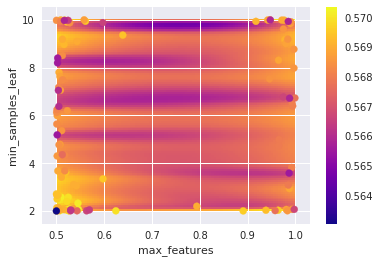

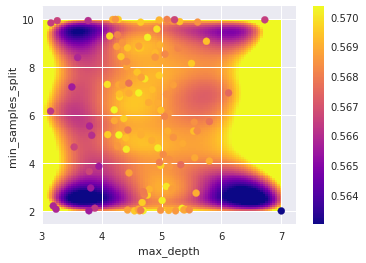

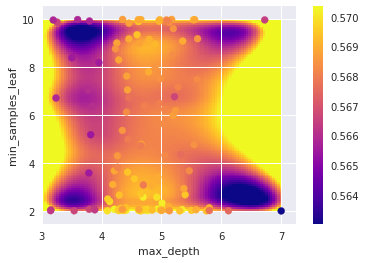

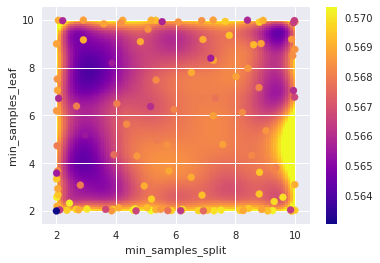

In [8]:
if (MODEL == "et") :
    graphBO(history_df, "max_features", "max_depth", et_max_features_min, et_max_features_max, et_max_depth_min, et_max_depth_max, 0.1)
    graphBO(history_df, "max_features", "min_samples_split", et_max_features_min, et_max_features_max, et_min_samples_split_min, et_min_samples_split_max, 0.06)
    graphBO(history_df, "max_features", "min_samples_leaf", et_max_features_min, et_max_features_max, et_min_samples_leaf_min, et_min_samples_leaf_max, 0.05)
    graphBO(history_df, "max_depth", "min_samples_split", et_max_depth_min, et_max_depth_max, et_min_samples_split_min, et_min_samples_split_max, 0.4)
    graphBO(history_df, "max_depth", "min_samples_leaf", et_max_depth_min, et_max_depth_max, et_min_samples_leaf_min, et_min_samples_leaf_max, 0.4)
    graphBO(history_df, "min_samples_split", "min_samples_leaf", et_min_samples_split_min, et_min_samples_split_max, et_min_samples_leaf_min, et_min_samples_leaf_max, 0.8)
elif (MODEL == "xg") :
    graphBO(history_df, "max_depth", "min_child_weight", xgb_max_depth_min, xgb_max_depth_max, xgb_min_child_weight_min, xgb_min_child_weight_max, 0.35)
    graphBO(history_df, "max_depth", "subsample", xgb_max_depth_min, xgb_max_depth_max, xgb_subsample_min, xgb_subsample_max, 10)
    graphBO(history_df, "max_depth", "colsample_bytree", xgb_max_depth_min, xgb_max_depth_max, xgb_colsample_bytree_min, xgb_colsample_bytree_max, 8)
    graphBO(history_df, "max_depth", "colsample_bylevel", xgb_max_depth_min, xgb_max_depth_max, xgb_colsample_bylevel_min, xgb_colsample_bylevel_max, 8)
    graphBO(history_df, "min_child_weight", "subsample", xgb_min_child_weight_min, xgb_min_child_weight_max, xgb_subsample_min, xgb_subsample_max, 20)
    graphBO(history_df, "min_child_weight", "colsample_bytree", xgb_min_child_weight_min, xgb_min_child_weight_max, xgb_colsample_bytree_min, xgb_colsample_bytree_max, 18)
    graphBO(history_df, "min_child_weight", "colsample_bylevel", xgb_min_child_weight_min, xgb_min_child_weight_max, xgb_colsample_bylevel_min, xgb_colsample_bylevel_max, 18)
    graphBO(history_df, "subsample", "colsample_bytree", xgb_subsample_min, xgb_subsample_max, xgb_colsample_bytree_min, xgb_colsample_bytree_max, 0.8)
    graphBO(history_df, "subsample", "colsample_bylevel", xgb_subsample_min, xgb_subsample_max, xgb_colsample_bylevel_min, xgb_colsample_bylevel_max, 0.8)
    graphBO(history_df, "colsample_bytree", "colsample_bylevel", xgb_colsample_bytree_min, xgb_colsample_bytree_max, xgb_colsample_bylevel_min, xgb_colsample_bylevel_max, 1)
else :
    graphBO(history_df, "max_depth", "num_leaves", max_depth_min, max_depth_max, num_leaves_min, num_leaves_max, 0.2)
    graphBO(history_df, "max_depth", "min_data_in_leaf", max_depth_min, max_depth_max, min_data_in_leaf_min, min_data_in_leaf_max, 0.2)
    graphBO(history_df, "max_depth", "feature_fraction", max_depth_min, max_depth_max, feature_fraction_min, feature_fraction_max, 8)
    graphBO(history_df, "max_depth", "bagging_fraction", max_depth_min, max_depth_max, bagging_fraction_min, bagging_fraction_max, 8)
    graphBO(history_df, "max_depth", "bagging_freq", max_depth_min, max_depth_max, bagging_freq_min, bagging_freq_max, 0.1)
    graphBO(history_df, "num_leaves", "min_data_in_leaf", num_leaves_min, num_leaves_max, min_data_in_leaf_min, min_data_in_leaf_max, 1)
    graphBO(history_df, "num_leaves", "feature_fraction", num_leaves_min, num_leaves_max, feature_fraction_min, feature_fraction_max, 25)
    graphBO(history_df, "num_leaves", "bagging_fraction", num_leaves_min, num_leaves_max, bagging_fraction_min, bagging_fraction_max, 25)
    graphBO(history_df, "num_leaves", "bagging_freq", num_leaves_min, num_leaves_max, bagging_freq_min, bagging_freq_max, 0.4)
    graphBO(history_df, "min_data_in_leaf", "feature_fraction", min_data_in_leaf_min, min_data_in_leaf_max, feature_fraction_min, feature_fraction_max, 25)
    graphBO(history_df, "min_data_in_leaf", "bagging_fraction", min_data_in_leaf_min, min_data_in_leaf_max, bagging_fraction_min, bagging_fraction_max, 25)
    graphBO(history_df, "min_data_in_leaf", "bagging_freq", min_data_in_leaf_min, min_data_in_leaf_max, bagging_freq_min, bagging_freq_max, 0.5)
    graphBO(history_df, "feature_fraction", "bagging_fraction", feature_fraction_min, feature_fraction_max, bagging_fraction_min, bagging_fraction_max, 1)
    graphBO(history_df, "feature_fraction", "bagging_freq", feature_fraction_min, feature_fraction_max, bagging_freq_min, bagging_freq_max, 0.01)
    graphBO(history_df, "bagging_fraction", "bagging_freq", bagging_fraction_min, bagging_fraction_max, bagging_freq_min, bagging_freq_max, 0.01)